In [1]:
from typing import Iterator, Callable
from functools import reduce

import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt

from solved_helium_eq import lambdified

In [2]:
the = pd.read_excel('Data/the_helium.xlsx').set_index('photon (eV)')
the

,inten_w (W/cm2),inten_2w (W/cm2),coeff_s,coeff_p,coeff_d,eta_s,eta_p,eta_d
photon (eV),,,,,,,,
14.3,10000000000000,13600000000,0.003220,0.01140,-0.01090,5.36,2.26,0
15.0,10000000000000,13400000000,0.002530,0.01050,-0.01020,5.22,2.19,0
15.9,10000000000000,12500000000,0.001770,0.00944,-0.00928,5.07,2.12,0
16.0,10000000000000,12600000000,0.001690,0.00933,-0.00917,5.06,2.11,0
17.0,10000000000000,11800000000,0.000986,0.00830,-0.00824,4.94,2.06,0
18.0,10000000000000,11300000000,0.000339,0.00746,-0.00745,4.84,2.01,0
19.0,10000000000000,11100000000,-0.000392,0.00685,-0.00684,4.77,1.98,0
19.1,10000000000000,11000000000,-0.000601,0.00676,-0.00673,4.76,1.98,0
19.5,10000000000000,11400000000,-0.001020,0.00669,-0.00661,4.73,1.97,0


In [3]:
exp = pd.read_excel('Data/exp_gauss3.xlsx').set_index('dataset')
exp['photon (eV)'] = pd.Series({'good1': 15.9, 'good2': 14.3, 'good3': 19.1, 'good4': 15.9})
exp[['photon (eV)', *[k for k in exp if k.startswith('he_')]]]
exp

,he_beta1_amp_err,he_beta1_amp_value,he_beta1_freq_err,he_beta1_freq_value,he_beta1_offset_err,he_beta1_offset_value,he_beta1_shift_err,he_beta1_shift_value,he_beta1m3_amp_err,he_beta1m3_amp_value,...,ne_beta3_amp_value,ne_beta3_freq_err,ne_beta3_freq_value,ne_beta3_offset_err,ne_beta3_offset_value,ne_beta3_shift_err,ne_beta3_shift_value,ne_beta4_c_err,ne_beta4_c_value,photon (eV)
dataset,,,,,,,,,,,,,,,,,,,,,
good1,0.016970,0.534221,0,6.283185,0.012729,-0.011979,0.034757,0.236018,0.007805,0.113821,...,0.398722,0,6.283185,0.010687,-0.039238,0.037330,-0.182652,0.015320,0.432741,15.9
good2,0.005097,0.347818,0,6.283185,0.003756,-0.072793,0.015513,0.075804,0.008122,0.141339,...,0.197069,0,6.283185,0.004613,-0.012368,0.030744,-1.145020,0.003214,-0.030674,14.3
good3,0.004871,0.496982,0,6.283185,0.003367,-0.040736,0.009357,5.368111,0.003144,0.029859,...,0.267384,0,6.283185,0.002348,-0.036890,0.012146,4.939388,0.003633,0.024581,19.1
good4,0.012234,0.281430,0,6.283185,0.008562,-0.088810,0.042583,4.612789,0.003706,0.056858,...,0.233538,0,6.283185,0.006152,-0.024713,0.037645,4.182441,0.005237,0.095546,15.9


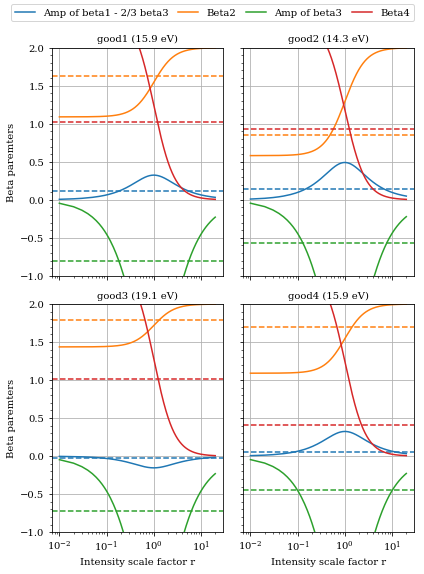

In [5]:
r = np.linspace(0, 20, 2001)[1:]

plt.style.use("Report.mplstyle")
plt.figure(figsize=(6,8))
for i, (dataset, m) in enumerate(exp.iterrows()):
    photon = m['photon (eV)']
    ref = the.loc[photon]
    d = lambdified(
        coeff_s=ref['coeff_s'], coeff_p=r*ref['coeff_p'], coeff_d=ref['coeff_d'],
        eta_s=ref['eta_s'], eta_p=ref['eta_p'], eta_d=ref['eta_d'],
    )
    keys = [
        # {'d': 'beta1_amp',
        #  'm': 'he_beta1_amp_value'},
        {'label': 'Amp of beta1 - 2/3 beta3',
         'd': 'beta1m3_amp',
         'm': 'he_beta1m3_amp_value'},
        {'label': 'Beta2',
         'd': 'beta2',
         'm': 'he_beta2_c_value'},
        {'label': 'Amp of beta3',
         'd': 'beta3_amp',
         'm': 'he_beta3_amp_value'},
        {'label': 'Beta4',
         'd': 'beta4',
         'm': 'he_beta4_c_value'},
    ]

    plt.subplot(2, 2, i+1)
    plt.title(f"{dataset} ({m['photon (eV)']} eV)")
    plt.xlabel('Intensity scale factor r')
    plt.ylabel('Beta paremters')
    plt.gca().label_outer()
    for k, prop in zip(keys, plt.rcParams['axes.prop_cycle']):
        if k['d'].endswith('_amp'):
            sign = np.sign(d[k['d']])[-1]
        else:
            sign = 1
        plt.plot(r, d[k['d']], label=k['label'], **prop)
        plt.axhline(sign*m[k['m']], linestyle='dashed', **prop)
    plt.grid(True)
    plt.xscale('log')
    plt.ylim(-1, 2)
    # plt.legend()
    if i == 0:
        plt.figlegend(loc='upper center', ncol=4, columnspacing=1)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig("Figures/Estimate intensity ratio.pdf")
plt.show()